In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data.shape

(161764, 33538)

In [4]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


## Read features

In [7]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,13,0
B_intermediate,19,8
B_memory,35,18
B_naive,8,4
CD14_Mono,15,9
CD16_Mono,11,6
CD4_CTL,111,42
CD4_Naive,124,63
CD4_Proliferating,96,53
CD4_TCM,56,28


## Build classifiers (K-fold CV)

In [11]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [13]:
import pickle
from sklearn.model_selection import StratifiedKFold

def LR_strat_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }

    skf = StratifiedKFold(n_splits=k, shuffle=True)
    cv_results = cross_validate(clf, X, y, cv=skf, scoring=scoring, n_jobs=-1)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics


In [33]:
# do it the old way (without kfold)
celltype = 'CD8_T'
# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]
metrics

[0.9706673260594072,
 0.9209831403615681,
 0.8900667451904201,
 0.9052610562044524,
 0.9884516012570196,
 0.9585112851124526,
 0.8880955201433167]

In [14]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\LR_classifiers_all")

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_loss_diff_l2.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: ASDC


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.999486907157606, 0.0, 0.0, 0.0, 0.9393868525610548, 0.009071853936266638, -0.00010921646103745389]
K-fold CV for: B_intermediate
[0.9904243191367922, 0.7513133573127286, 0.5450325753542729, 0.6303103982305343, 0.9929414291024401, 0.7071937715958297, 0.6345973207397633]
K-fold CV for: B_memory
[0.9953141582364644, 0.900775611001778, 0.8648401826484019, 0.8820803191070421, 0.9986501052341538, 0.9504649631305672, 0.8800689870495013]
K-fold CV for: B_naive
[0.9945970648095809, 0.9442838536065375, 0.9426001262596584, 0.9433333538167691, 0.9990945483036686, 0.9822625687139986, 0.9405566569267945]
K-fold CV for: CD14_Mono
[0.9886253999410496, 0.9723350940889853, 0.9849379245724995, 0.9785892028750638, 0.998488321089129, 0.9935047491012166, 0.9708888225600836]
K-fold CV for: CD16_Mono
[0.993719253382942, 0.9145001897144622, 0.9272151898734178, 0.9205059876278578, 0.9982267769862243, 0.9498560957837036, 0.917427966253498]
K-fold CV for: CD4_CTL


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.9961548941078178, 0.8590201629064159, 0.7696114478783663, 0.8104284317365547, 0.9966959665531274, 0.8895244234881238, 0.8104697475262851]
K-fold CV for: CD4_Naive


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[0.9647017101975021, 0.8479573145692678, 0.8291654635749666, 0.8367733025145208, 0.98819561371682, 0.9100880790067825, 0.818119161698457]
K-fold CV for: CD4_Proliferating
[0.9996538169004425, 0.7633857370699476, 0.7238095238095238, 0.732874790714512, 0.9907131219045665, 0.8028486901654821, 0.7380187477735861]
K-fold CV for: CD4_TCM
[0.956084196990157, 0.7940637630451549, 0.7232830252441316, 0.7518754634506776, 0.9801310232740384, 0.8393432820349485, 0.7319101017874804]
K-fold CV for: CD4_TEM
[0.9759402573835982, 0.650800480202226, 0.200149947109565, 0.3044190079663068, 0.9560790292834713, 0.4523859025292758, 0.3509485498739565]
K-fold CV for: CD8_Naive
[0.9879206930576017, 0.9251565724624402, 0.8917170271793671, 0.9078009689033214, 0.9952687208820723, 0.9634343510168952, 0.9017029457510881]
K-fold CV for: CD8_Proliferating
[0.9995178160012372, 0.5755952380952382, 0.5035087719298245, 0.5335294117647059, 0.9987586136770551, 0.558980691932066, 0.5362835501404092]
K-fold CV for: CD8_TCM


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

[0.9894414223423649, 0.7570156136899048, 0.6260849942229926, 0.6811980778797568, 0.9848279344742688, 0.7434484071541233, 0.6811657939798139]
K-fold CV for: CD8_TEM
[0.9792351923940661, 0.8729118003536614, 0.83771998611255, 0.8535861706913461, 0.9920033668393508, 0.9248853760092025, 0.8434159708421177]
K-fold CV for: Doublet
[0.9967607125257075, 0.9037037037037037, 0.15206611570247935, 0.2579193281115325, 0.9008529442337352, 0.4757255667616723, 0.36642519022592807]
K-fold CV for: Eryth
[0.9995116343853748, 0.553968253968254, 0.20514705882352943, 0.29406926406926404, 0.9859829113831751, 0.26395790223427035, 0.33312444559298743]
K-fold CV for: HSPC
[0.9980650835355643, 0.5785714285714285, 0.24326340326340326, 0.3349436002348086, 0.9817428218636135, 0.4529875970619626, 0.3695479156474505]
K-fold CV for: ILC


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\evanlee\AppData\

[0.9991778147086221, 0.0, 0.0, 0.0, 0.7374388430459241, 0.0017595991644851392, -3.213551960510983e-05]
K-fold CV for: MAIT
[0.9940407000829101, 0.838070259255422, 0.8114022964752076, 0.8237383826308122, 0.9968769970565894, 0.8829999774759963, 0.8212243940828877]
K-fold CV for: NK
[0.9826599082808789, 0.9080506853308064, 0.9323356553482217, 0.9197355656178411, 0.9967488137475355, 0.9682259488545695, 0.9103061296320369]
K-fold CV for: NK_CD56bright
[0.9978610806581196, 0.8447407989073478, 0.778396937971406, 0.8093573475601179, 0.9991008946129366, 0.9006777853447618, 0.8093990198399771]
K-fold CV for: NK_Proliferating
[0.9985967216077052, 0.8183505489290909, 0.7571643035863219, 0.7852688576278958, 0.9987284373736631, 0.8583366682134376, 0.7858162496403243]
K-fold CV for: Plasmablast
[0.999678543746052, 0.9712554112554113, 0.885190670122177, 0.9256444003704182, 0.9981856308004543, 0.9448223462152411, 0.926776538071042]
K-fold CV for: Platelet
[0.998417448442064, 0.969075235405058, 0.917552

In [15]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999487,0.000000,0.000000,0.000000,0.939387,0.009072,-0.000109
B_intermediate,0.990424,0.751313,0.545033,0.630310,0.992941,0.707194,0.634597
B_memory,0.995314,0.900776,0.864840,0.882080,0.998650,0.950465,0.880069
B_naive,0.994597,0.944284,0.942600,0.943333,0.999095,0.982263,0.940557
CD14_Mono,0.988625,0.972335,0.984938,0.978589,0.998488,0.993505,0.970889
CD16_Mono,0.993719,0.914500,0.927215,0.920506,0.998227,0.949856,0.917428
CD4_CTL,0.996155,0.859020,0.769611,0.810428,0.996696,0.889524,0.810470
CD4_Naive,0.964702,0.847957,0.829165,0.836773,0.988196,0.910088,0.818119
CD4_Proliferating,0.999654,0.763386,0.723810,0.732875,0.990713,0.802849,0.738019
CD4_TCM,0.956084,0.794064,0.723283,0.751875,0.980131,0.839343,0.731910


In [16]:
!cd

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\LR_classifiers_all


In [17]:
# save metrics
all_metrics.to_csv('LR_metrics_loss_diff_l2.csv')

## Plot classifier K-fold CV metrics

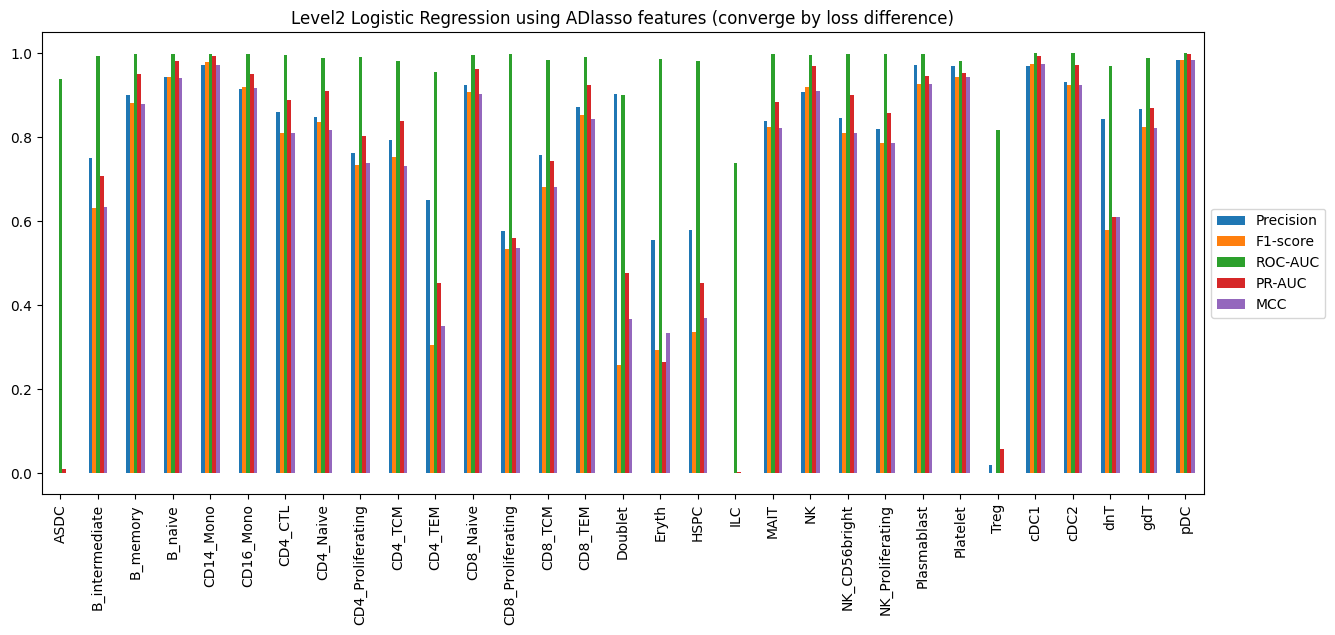

In [22]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics[cols].plot.bar(rot=90, figsize=(15,6), title='Level2 Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Evaluate by DEGn

In [24]:
count_df

,Feature_count,Positive_feature_count
ASDC,13,0
B_intermediate,19,8
B_memory,35,18
B_naive,8,4
CD14_Mono,15,9
CD16_Mono,11,6
CD4_CTL,111,42
CD4_Naive,124,63
CD4_Proliferating,96,53
CD4_TCM,56,28


In [25]:
# Read DEG table
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\L2_DEG\L2_DEG_table")

# celltype = 'ASDC'
DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
# n_features = count_df.loc[celltype, 'Feature_count']  # 3902
# DEGn = DEG_table['names'][:n_features].tolist()

In [30]:
def LR_classifier_DEG(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [29]:
!cd

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\L2_DEG\L2_DEG_table


In [31]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier_DEG(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: ASDC
n: 13
(161764, 13)
Constructing classifier for: B_intermediate
n: 19
(161764, 19)
Constructing classifier for: B_memory
n: 35
(161764, 35)
Constructing classifier for: B_naive
n: 8
(161764, 8)
Constructing classifier for: CD14_Mono
n: 15
(161764, 15)
Constructing classifier for: CD16_Mono
n: 11
(161764, 11)
Constructing classifier for: CD4_CTL
n: 111
(161764, 111)
Constructing classifier for: CD4_Naive
n: 124
(161764, 124)


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: CD4_Proliferating
n: 96
(161764, 96)
Constructing classifier for: CD4_TCM
n: 56
(161764, 56)
Constructing classifier for: CD4_TEM
n: 22
(161764, 22)
Constructing classifier for: CD8_Naive
n: 41
(161764, 41)
Constructing classifier for: CD8_Proliferating
n: 62
(161764, 62)
Constructing classifier for: CD8_TCM
n: 795
(161764, 795)


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: CD8_TEM
n: 37
(161764, 37)
Constructing classifier for: Doublet
n: 24
(161764, 24)
Constructing classifier for: Eryth
n: 2
(161764, 2)
Constructing classifier for: HSPC
n: 5
(161764, 5)
Constructing classifier for: ILC
n: 3
(161764, 3)
Constructing classifier for: MAIT
n: 13
(161764, 13)
Constructing classifier for: NK
n: 25
(161764, 25)
Constructing classifier for: NK_CD56bright
n: 30
(161764, 30)
Constructing classifier for: NK_Proliferating
n: 44
(161764, 44)
Constructing classifier for: Plasmablast
n: 3
(161764, 3)
Constructing classifier for: Platelet
n: 4
(161764, 4)
Constructing classifier for: Treg
n: 4
(161764, 4)


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Constructing classifier for: cDC1
n: 64
(161764, 64)
Constructing classifier for: cDC2
n: 11
(161764, 11)
Constructing classifier for: dnT
n: 49
(161764, 49)
Constructing classifier for: gdT
n: 24
(161764, 24)
Constructing classifier for: pDC
n: 17
(161764, 17)


In [32]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999969,1.000000,0.933333,0.965517,0.999998,0.995833,0.966077
B_intermediate,0.986029,0.717949,0.115226,0.198582,0.983321,0.456579,0.284086
B_memory,0.990295,0.783471,0.721461,0.751189,0.994979,0.834005,0.746908
B_naive,0.994004,0.945839,0.927461,0.936560,0.998919,0.971513,0.933463
CD14_Mono,0.988625,0.971927,0.985360,0.978597,0.998405,0.994786,0.970895
CD16_Mono,0.993571,0.913146,0.923259,0.918175,0.998143,0.949780,0.914844
CD4_CTL,0.991716,0.665272,0.458213,0.542662,0.989902,0.615541,0.548184
CD4_Naive,0.957098,0.815380,0.779462,0.797017,0.982984,0.872627,0.773290
CD4_Proliferating,0.999536,0.640000,0.727273,0.680851,0.969431,0.741537,0.682013
CD4_TCM,0.921893,0.632413,0.361652,0.460158,0.935888,0.552701,0.440599


In [33]:
os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\L2_DEG')
all_metrics_DEG.to_csv('L2_loss_diff_DEGn_LR_metrics.csv')

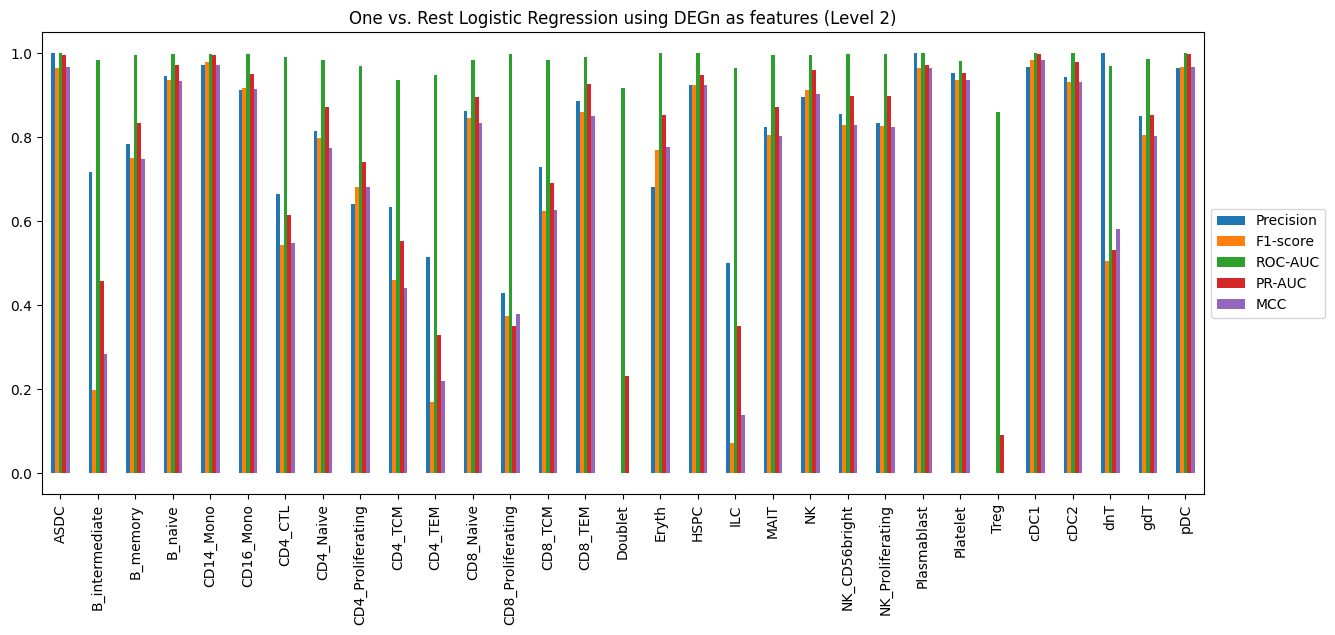

In [35]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics_DEG[cols].plot.bar(rot=90, figsize=(15,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [36]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999487,0.000000,0.000000,0.000000,0.939387,0.009072,-0.000109
B_intermediate,0.990424,0.751313,0.545033,0.630310,0.992941,0.707194,0.634597
B_memory,0.995314,0.900776,0.864840,0.882080,0.998650,0.950465,0.880069
B_naive,0.994597,0.944284,0.942600,0.943333,0.999095,0.982263,0.940557
CD14_Mono,0.988625,0.972335,0.984938,0.978589,0.998488,0.993505,0.970889
CD16_Mono,0.993719,0.914500,0.927215,0.920506,0.998227,0.949856,0.917428
CD4_CTL,0.996155,0.859020,0.769611,0.810428,0.996696,0.889524,0.810470
CD4_Naive,0.964702,0.847957,0.829165,0.836773,0.988196,0.910088,0.818119
CD4_Proliferating,0.999654,0.763386,0.723810,0.732875,0.990713,0.802849,0.738019
CD4_TCM,0.956084,0.794064,0.723283,0.751875,0.980131,0.839343,0.731910


In [37]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999969,1.000000,0.933333,0.965517,0.999998,0.995833,0.966077
B_intermediate,0.986029,0.717949,0.115226,0.198582,0.983321,0.456579,0.284086
B_memory,0.990295,0.783471,0.721461,0.751189,0.994979,0.834005,0.746908
B_naive,0.994004,0.945839,0.927461,0.936560,0.998919,0.971513,0.933463
CD14_Mono,0.988625,0.971927,0.985360,0.978597,0.998405,0.994786,0.970895
CD16_Mono,0.993571,0.913146,0.923259,0.918175,0.998143,0.949780,0.914844
CD4_CTL,0.991716,0.665272,0.458213,0.542662,0.989902,0.615541,0.548184
CD4_Naive,0.957098,0.815380,0.779462,0.797017,0.982984,0.872627,0.773290
CD4_Proliferating,0.999536,0.640000,0.727273,0.680851,0.969431,0.741537,0.682013
CD4_TCM,0.921893,0.632413,0.361652,0.460158,0.935888,0.552701,0.440599


In [38]:
AD_minus_DEG = all_metrics - all_metrics_DEG
AD_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,-4.821838e-04,-1.000000,-0.933333,-0.965517,-6.061109e-02,-0.986761,-0.966186
B_intermediate,4.395203e-03,0.033365,0.429806,0.431729,9.620254e-03,0.250615,0.350511
B_memory,5.019595e-03,0.117305,0.143379,0.130892,3.671025e-03,0.116460,0.133161
B_naive,5.934175e-04,-0.001555,0.015139,0.006774,1.751869e-04,0.010750,0.007094
CD14_Mono,-7.528536e-08,0.000408,-0.000422,-0.000008,8.292130e-05,-0.001282,-0.000006
CD16_Mono,1.483326e-04,0.001355,0.003956,0.002331,8.371100e-05,0.000076,0.002584
CD4_CTL,4.438515e-03,0.193748,0.311398,0.267766,6.793767e-03,0.273983,0.262286
CD4_Naive,7.603450e-03,0.032577,0.049703,0.039757,5.211442e-03,0.037461,0.044829
CD4_Proliferating,1.174524e-04,0.123386,-0.003463,0.052024,2.128187e-02,0.061312,0.056006
CD4_TCM,3.419133e-02,0.161650,0.361631,0.291717,4.424254e-02,0.286642,0.291311


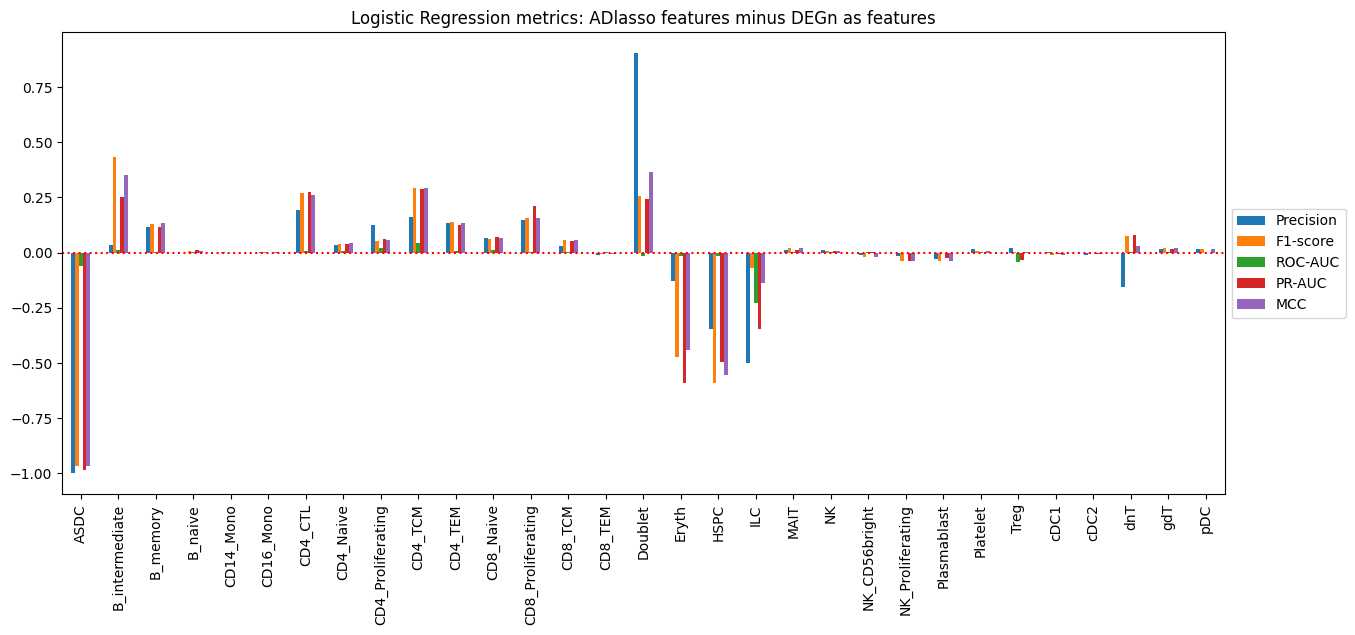

In [39]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = AD_minus_DEG[cols].plot.bar(rot=90, figsize=(15,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
